In [71]:
# %%
import cuqi
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

## 0. Introduction
This notebook demos to use CUQIpy to perform inverse sampling for a toy 2D quadratic problem. The problem is formulated as
$$y = A(x) + \epsilon$$
where the forward operator $A$ is a quadratic function $x_1^2 + x_2^2$ and $\epsilon\sim\mathcal{N}(0, 0.1^2)$.

We are performing 4 experiments in this notebook. Specifically, we will draw samples from the posterior with
1. a non-informative/uniform prior,
2. a nonnegativity prior,
3. a L1 prior, and
4. a TV prior.

Specifically, the first experiment is performed with NUTS and the rest are done with MYULA where the prior is smoothed by Moreau-Yoshida approximation.

We start by defining the forward operator and generating the 1D synthetic observation data.

In [2]:
# %%
def forward(x):
    return x[0]**2 + x[1]**2

def jacobian(x):
    return np.array([[2*x[0], 2*x[1]]])

A = cuqi.model.Model(forward, jacobian=jacobian,domain_geometry=2,range_geometry=1)

x_true = np.array([1, 2])
noise_std = 0.1
y_true = A(x_true)
y_obs = y_true + np.random.randn(1)*noise_std

## 1. Likelihood only posterior

In [3]:
# %%
y = cuqi.distribution.Gaussian(A, noise_std**2*np.eye(1))
data_dist = y(y=y_obs)
np.random.seed(0)
sampler_likelihood = cuqi.experimental.mcmc.NUTS(data_dist)
sampler_likelihood.sample(int(1e4))
samples_likelihood = sampler_likelihood.get_samples().burnthin(1000, 10)

Sample: 100%|██████████| 10000/10000 [01:16<00:00, 130.12it/s, acc rate: 94.06%]


4.8 4.8


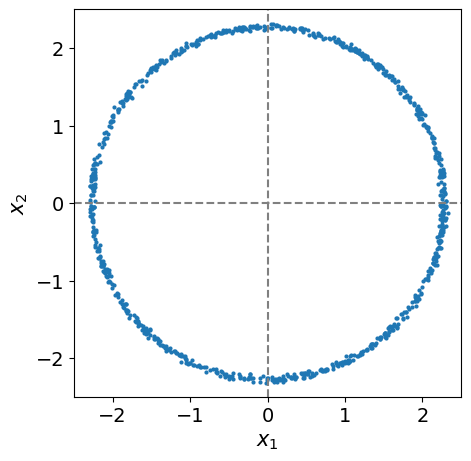

In [4]:
plt.subplots(figsize=(4.8, 4.8))
samples_likelihood.plot_pair(ax=plt.gca())
# plt.title("Likelihood only")
ax = plt.gca()
ax.set_box_aspect(1)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
plt.hlines(0, -2.5, 2.5, color="gray", linestyles="--")
plt.vlines(0, -2.5, 2.5, color="gray", linestyles="--")
plt.tight_layout()
fig_width, fig_height = plt.gcf().get_size_inches()
print(fig_width, fig_height)
plt.savefig("simplest_nonlinear_likelihood_only.pdf", bbox_inches = 'tight')

## 2. Likelihood + Moreau-Yoshida-smoothed nonnegativity prior

In [5]:
# %%
np.random.seed(0)
def my_proximal(x, restoration_strength):
    return np.maximum(x,0), None
restorator = cuqi.implicitprior.RestorationPrior(
    my_proximal,
    restorator_kwargs={},
    geometry=2
)

smoothing_strength = 1e-3

x = cuqi.implicitprior.MoreauYoshidaPrior(prior=restorator, smoothing_strength=smoothing_strength)

y = cuqi.distribution.Gaussian(A, noise_std**2)
joint = cuqi.distribution.JointDistribution(x, y)
post = joint(y=y_obs)

sampler_nonnegativity = cuqi.experimental.mcmc.ULA(post, scale=1e-3, initial_point=np.array([0.5,0.5]))
sampler_nonnegativity.sample(int(1e5))

Sample: 100%|██████████| 100000/100000 [02:58<00:00, 560.28it/s, acc rate: 100.00%]


Sampler: ULA 
 Target: 
 	 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [0.06051639 2.26130572] 
	 current_target_grad: [ 0.71699145 26.79169994] 
	 scale: 0.001 

4.8 4.8


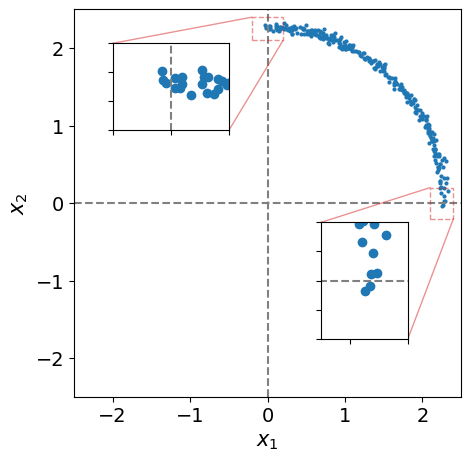

In [69]:
samples_nonnegativity = sampler_nonnegativity.get_samples().burnthin(int(1e4),300)
plt.subplots(figsize=(4.8, 4.8))
samples_nonnegativity.plot_pair(ax=plt.gca())
plt.hlines(0, -2.5, 2.5, color="gray", linestyles="--")
plt.vlines(0, -2.5, 2.5, color="gray", linestyles="--")
ax = plt.gca()
ax.set_box_aspect(1)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

axins = ax.inset_axes(
    [0.1, 0.65, 0.3, 0.3],#[-0.6, 0.55, 0.5, 0.5],
    xlim=(-0.2, 0.2), ylim=(2.1, 2.4), xticklabels=[], yticklabels=[])
axins.scatter(samples_nonnegativity.samples[0,:], samples_nonnegativity.samples[1,:])
axins.vlines(0, 0, 2.5, color="gray", linestyles="--")

axins.set_aspect('equal')
ax.indicate_inset_zoom(axins, edgecolor="tab:red", linestyle="--")

axins = ax.inset_axes(
    [0.6, 0.15, 0.3, 0.3], #[1.2, 0.25, 0.5, 0.5],
    xlim=(2.1, 2.4), ylim=(-0.2, 0.2), xticklabels=[], yticklabels=[])
axins.scatter(samples_nonnegativity.samples[0,:], samples_nonnegativity.samples[1,:])
axins.hlines(0, 0, 2.5, color="gray", linestyles="--")
axins.set_aspect('equal')


ax.indicate_inset_zoom(axins, edgecolor="tab:red", linestyle="--")

plt.tight_layout()
fig_width, fig_height = plt.gcf().get_size_inches()
print(fig_width, fig_height)
plt.savefig("simplest_nonlinear_nonnegativity.pdf", bbox_inches = 'tight')

## 3. Likelihood + Moreau-Yoshida-smoothed L1 prior

In [7]:
# %%
np.random.seed(0)

restorator_kwargs = {}
restorator_kwargs["regularization_strength"] = 10 #5

def ProximalL1(x, gamma):
    return np.multiply(np.sign(x), np.maximum(np.abs(x)-gamma, 0))

def prox_g(x, regularization_strength=None, restoration_strength=None):
    weight = regularization_strength * restoration_strength
    return ProximalL1(x, gamma=weight), None

restorator = cuqi.implicitprior.RestorationPrior(
    prox_g,
    restorator_kwargs=restorator_kwargs,
    geometry=2
)

smoothing_strength = 1e-6#1e-4

x = cuqi.implicitprior.MoreauYoshidaPrior(prior=restorator, smoothing_strength=smoothing_strength)

y = cuqi.distribution.Gaussian(A, noise_std**2)
joint = cuqi.distribution.JointDistribution(x, y)
post = joint(y=y_obs)

Sample: 100%|██████████| 50000/50000 [01:02<00:00, 793.82it/s, acc rate: 100.00%] 


Sampler: ULA 
 Target: 
 	 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [-0.10533457  1.40556667] 
	 current_target_grad: [-57.19696829 886.66500803] 
	 scale: 0.0025 

In [43]:
# %%
np.random.seed(0)
sampler_l1_1 = cuqi.experimental.mcmc.ULA(post, scale=1e-3, initial_point=np.array([1.0,0.0])) # scale = 2.5e-3
sampler_l1_1.sample(int(5e4))
sampler_l1_2 = cuqi.experimental.mcmc.ULA(post, scale=1e-3, initial_point=np.array([0.0,1.0])) # scale = 2.5e-3
sampler_l1_2.sample(int(5e4))
sampler_l1_3 = cuqi.experimental.mcmc.ULA(post, scale=1e-3, initial_point=np.array([-1.0,0.0])) # scale = 2.5e-3
sampler_l1_3.sample(int(5e4))
sampler_l1_4 = cuqi.experimental.mcmc.ULA(post, scale=1e-3, initial_point=np.array([0.0,-1.0])) # scale = 2.5e-3
sampler_l1_4.sample(int(5e4))

Sample: 100%|██████████| 50000/50000 [01:01<00:00, 815.73it/s, acc rate: 100.00%] 


Sampler: ULA 
 Target: 
 	 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [-0.05364668 -2.25178509] 
	 current_target_grad: [  8.89497292 -36.3828017 ] 
	 scale: 0.001 

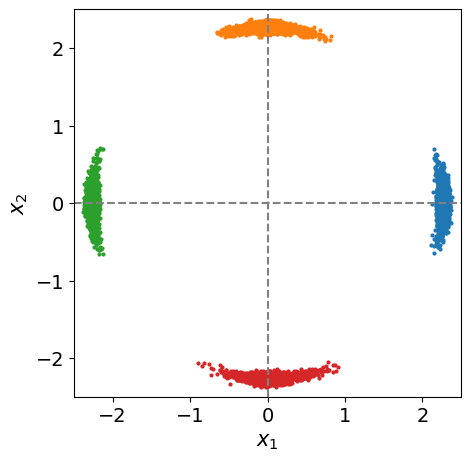

In [44]:
samples_l1_1 = sampler_l1_1.get_samples().burnthin(int(1e3),10)
samples_l1_2 = sampler_l1_2.get_samples().burnthin(int(1e3),10)
samples_l1_3 = sampler_l1_3.get_samples().burnthin(int(1e3),10)
samples_l1_4 = sampler_l1_4.get_samples().burnthin(int(1e3),10)

plt.subplots(figsize=(4.8, 4.8))
samples_l1_1.plot_pair(ax=plt.gca())
samples_l1_2.plot_pair(ax=plt.gca())
samples_l1_3.plot_pair(ax=plt.gca())
samples_l1_4.plot_pair(ax=plt.gca())
ax = plt.gca()
ax.set_box_aspect(1)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.hlines(0, -2.5, 2.5, color="gray", linestyles="--")
ax.vlines(0, -2.5, 2.5, color="gray", linestyles="--")
plt.tight_layout()
plt.savefig("simplest_nonlinear_l1.pdf", bbox_inches = 'tight')

array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>]],
      dtype=object)

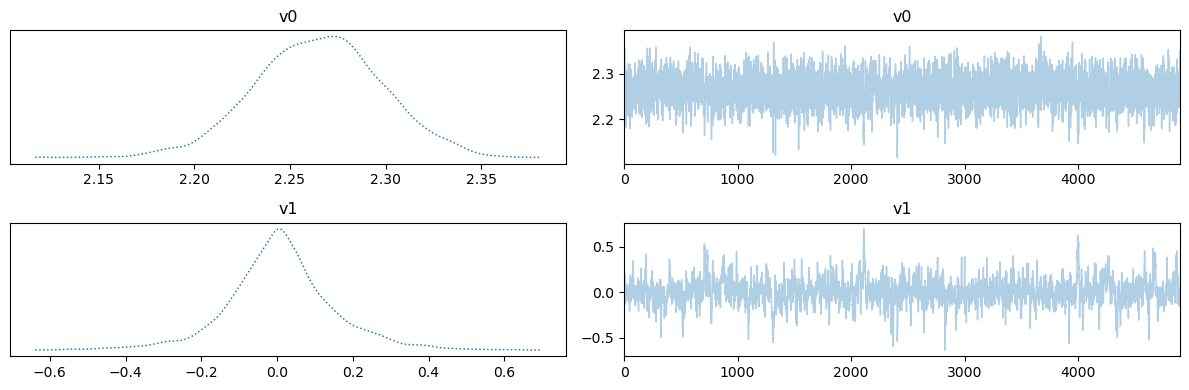

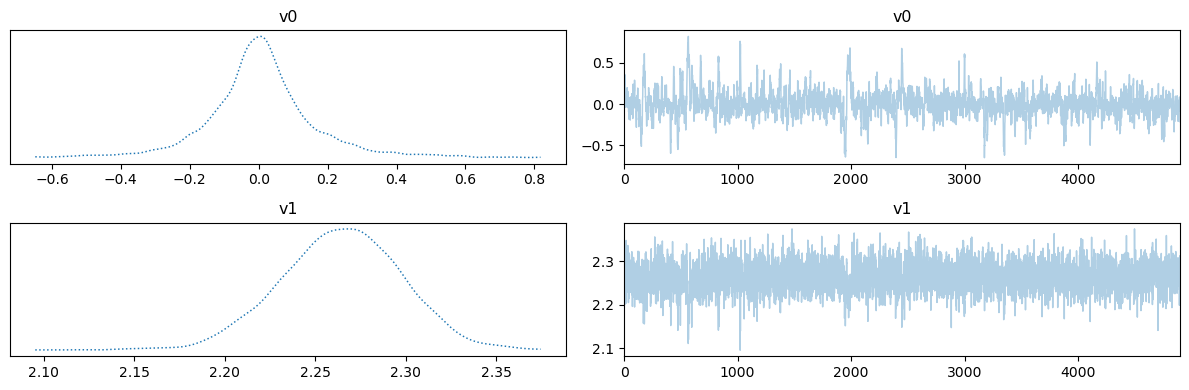

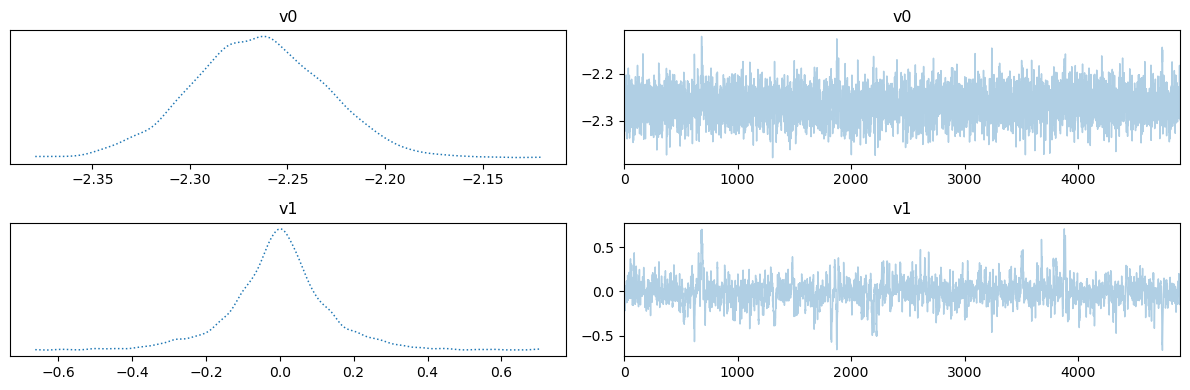

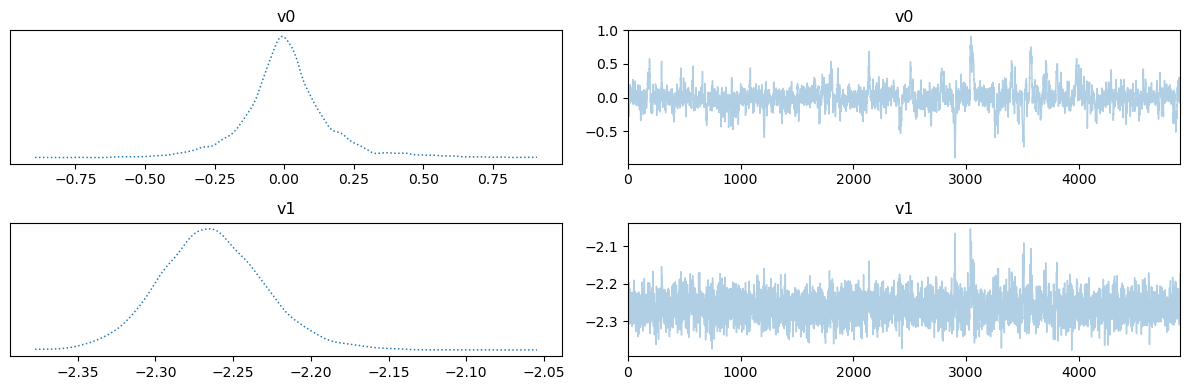

In [46]:
samples_l1_1.plot_trace()
samples_l1_2.plot_trace()
samples_l1_3.plot_trace()
samples_l1_4.plot_trace()

## 4. Likelihood + Moreau-Yoshida-smoothed TV prior

In [ ]:
# %%
np.random.seed(0)

from skimage.restoration import denoise_tv_chambolle

restorator_kwargs = {}
restorator_kwargs["regularization_strength"] = 5 #5

def prox_g(x, regularization_strength=None, restoration_strength=None):
    weight = regularization_strength * restoration_strength
    return denoise_tv_chambolle(x, weight=weight, max_num_iter=100), None

restorator = cuqi.implicitprior.RestorationPrior(
    prox_g,
    restorator_kwargs=restorator_kwargs,
    geometry=2
)

smoothing_strength = 1e-4#1e-3#1e-4

x = cuqi.implicitprior.MoreauYoshidaPrior(prior=restorator, smoothing_strength=smoothing_strength)

y = cuqi.distribution.Gaussian(A, noise_std**2)
joint = cuqi.distribution.JointDistribution(x, y)
post = joint(y=y_obs)

In [48]:
sampler_tv_1 = cuqi.experimental.mcmc.ULA(post, scale=1.0e-3, initial_point=np.array([0.5,0.5])) # scale = 2.5e-3
sampler_tv_1.sample(int(5e4))
sampler_tv_2 = cuqi.experimental.mcmc.ULA(post, scale=1.0e-3, initial_point=np.array([-0.5,-0.5])) # scale = 2.5e-3
sampler_tv_2.sample(int(5e4))

samples_tv_1 = sampler_tv_1.get_samples().burnthin(int(1e3),100)
samples_tv_2 = sampler_tv_2.get_samples().burnthin(int(1e3),100)

Sample: 100%|██████████| 50000/50000 [01:15<00:00, 661.15it/s, acc rate: 100.00%] 


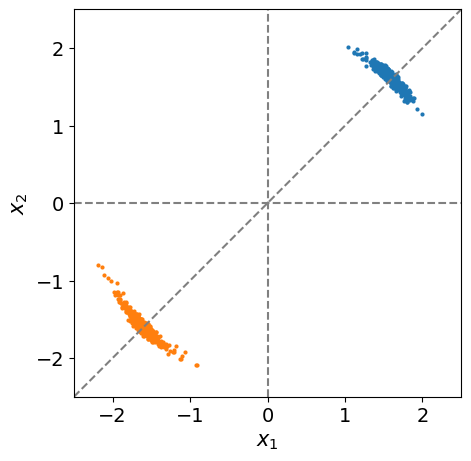

In [50]:
plt.subplots(figsize=(4.8, 4.8))
samples_tv_1.plot_pair(ax=plt.gca())
samples_tv_2.plot_pair(ax=plt.gca())
ax = plt.gca()
ax.set_box_aspect(1)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.plot([-2.5,2.5],[-2.5,2.5], color="gray", linestyle="--")
ax.hlines(0, -2.5, 2.5, color="gray", linestyles="--")
ax.vlines(0, -2.5, 2.5, color="gray", linestyles="--")
plt.tight_layout()
plt.savefig("simplest_nonlinear_tv.pdf", bbox_inches = 'tight')

array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>]],
      dtype=object)

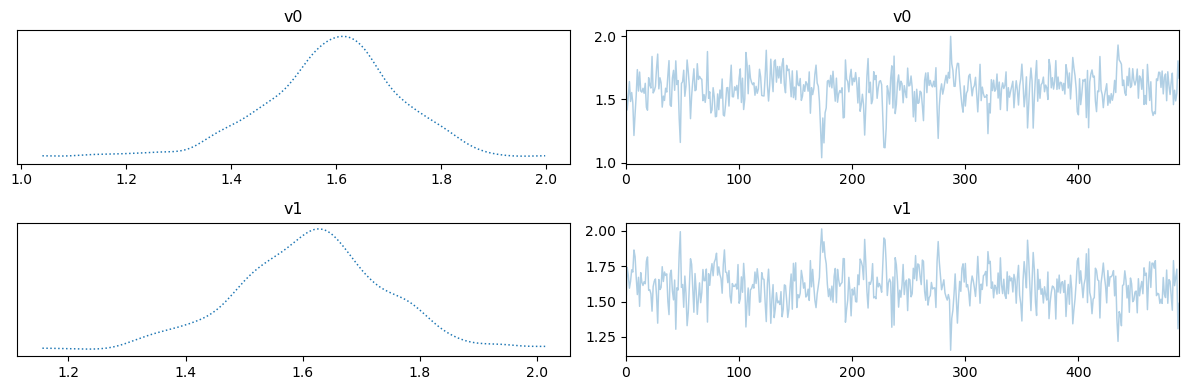

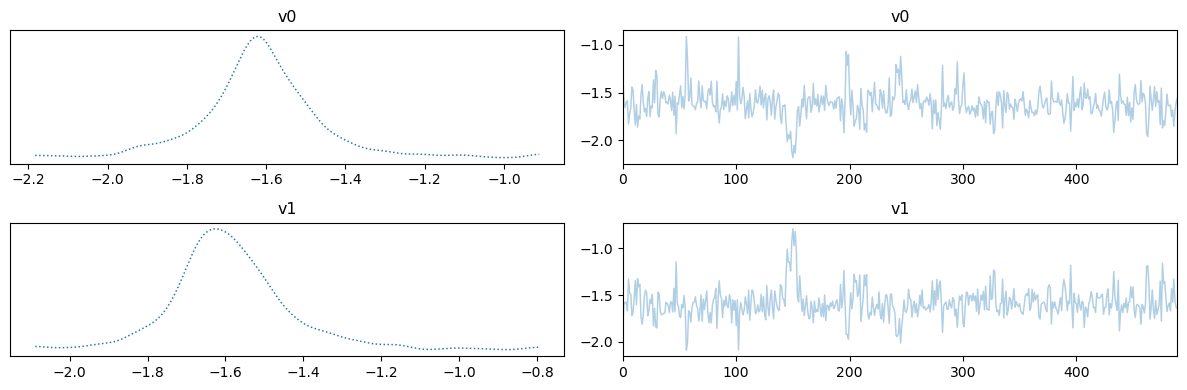

In [51]:
samples_tv_1.plot_trace()
samples_tv_2.plot_trace()